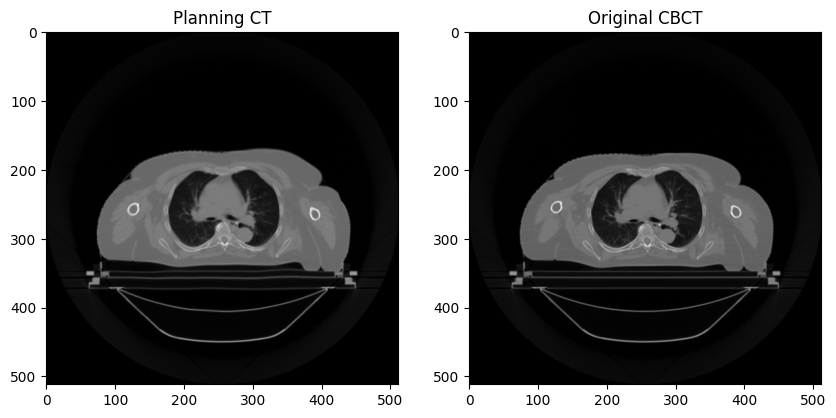

In [90]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

# Define file paths and load images.
DATASET_PATH = "dataloader/data/full/SAMPLE_001"
planned_ct_path = f'{DATASET_PATH}/CT.1.2.246.352.221.49998588991250185596277084171475165836.dcm'
cbct_path = f'{DATASET_PATH}/CT.1.2.246.352.221.505160349897793889516650021650971788930.dcm'

# Read the images and drop the extra dimension.
planning_ct = sitk.ReadImage(planned_ct_path)[:, :, 0]
cbct = sitk.ReadImage(cbct_path)[:, :, 0]

def get_array(image):
    """Helper function to convert a SimpleITK image to a numpy array for visualization."""
    return sitk.GetArrayFromImage(image)

# Optionally display original images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(get_array(planning_ct), cmap='gray')
plt.title("Planning CT")
plt.subplot(1, 2, 2)
plt.imshow(get_array(cbct), cmap='gray')
plt.title("Original CBCT")
plt.show()

def shift_image(image, shift):
    """
    Applies a translation shift to a SimpleITK image.
    
    Parameters:
        image (SimpleITK.Image): The image to be shifted.
        shift (tuple): The translation offset for each dimension (e.g., (dx, dy)).
    
    Returns:
        SimpleITK.Image: The shifted image.
    """
    # Create a translation transform with the given shift.
    transform = sitk.TranslationTransform(image.GetDimension())
    transform.SetOffset(shift)
    
    # Resample the image using the translation transform.
    shifted_image = sitk.Resample(image, image, transform, 
                                  sitk.sitkLinear, -1000, image.GetPixelID())
    return shifted_image

# Apply a shift to the CBCT image.
# For a 2D image, the shift is defined as (dx, dy) in physical units (typically mm if spacing is set)
# Here we use arbitrary values; adjust as needed based on your image spacing.
shift_offset = (1.0, 1.0)  # shift 10 mm in x-direction and 15 mm in y-direction
cbct_shifted = shift_image(cbct, shift_offset)

cbct = cbct_shifted
planning_ct_img = sitk.GetArrayFromImage(planning_ct)
cbct_img = sitk.GetArrayFromImage(cbct)

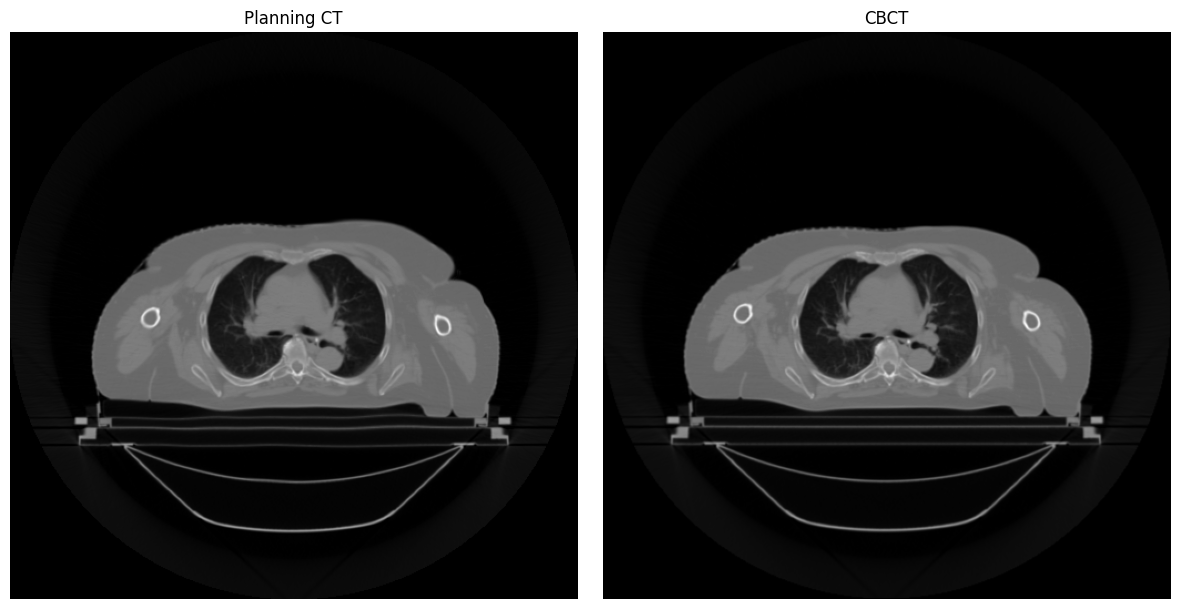

In [91]:
def plot_images(planning_ct, cbct):
    planning_ct_img = sitk.GetArrayFromImage(planning_ct)
    cbct_img = sitk.GetArrayFromImage(cbct)   
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(planning_ct_img, cmap='gray')
    plt.title('Planning CT')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cbct_img, cmap='gray')
    plt.title('CBCT')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
plot_images(planning_ct, cbct)

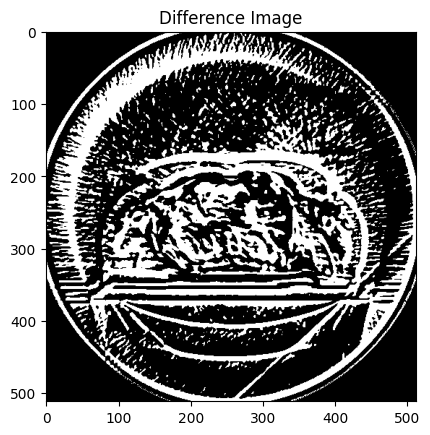

In [92]:
smoothed_planning = sitk.SmoothingRecursiveGaussian(planning_ct, sigma=2.0)
smoothed_cbct = sitk.SmoothingRecursiveGaussian(cbct, sigma=2.0)

def plot_difference(planning_ct, cbct_ct):
    planning_img = sitk.GetArrayFromImage(planning_ct)
    cbct_img = sitk.GetArrayFromImage(cbct_ct)
    diff = planning_img - cbct_img
    diff[diff < 0] = 0
    diff[diff > 0] = 255
    plt.imshow(diff, cmap='gray')
    plt.title('Difference Image')   
    plt.show()
    
plot_difference(smoothed_planning, smoothed_cbct)
# diff = smoothed_planning_img - smoothed_cbct_img
# diff[diff < 0] = 0
# diff[diff > 0] = 255
# plt.imshow(diff, cmap='gray')
# plt.show()


# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(smoothed_planning_img, cmap='gray')
# plt.title('Planning CT')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(smoothed_cbct_img, cmap='gray')
# plt.title('CBCT')
# plt.axis('off')

# plt.tight_layout()
# plt.show()

itk::simple::Euler2DTransform
 Euler2DTransform (0x7fda167e0120)
   RTTI typeinfo:   itk::Euler2DTransform<double>
   Reference Count: 3
   Modified Time: 950733
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1 -0.000777556 
     0.000777556 1 
   Offset: [-0.99226, -1.15736]
   Center: [-0.6914, 95.3086]
   Translation: [-1.06637, -1.15792]
   Inverse: 
     1 0.000777556 
     -0.000777556 1 
   Singular: 0
   Angle: 0.000777556



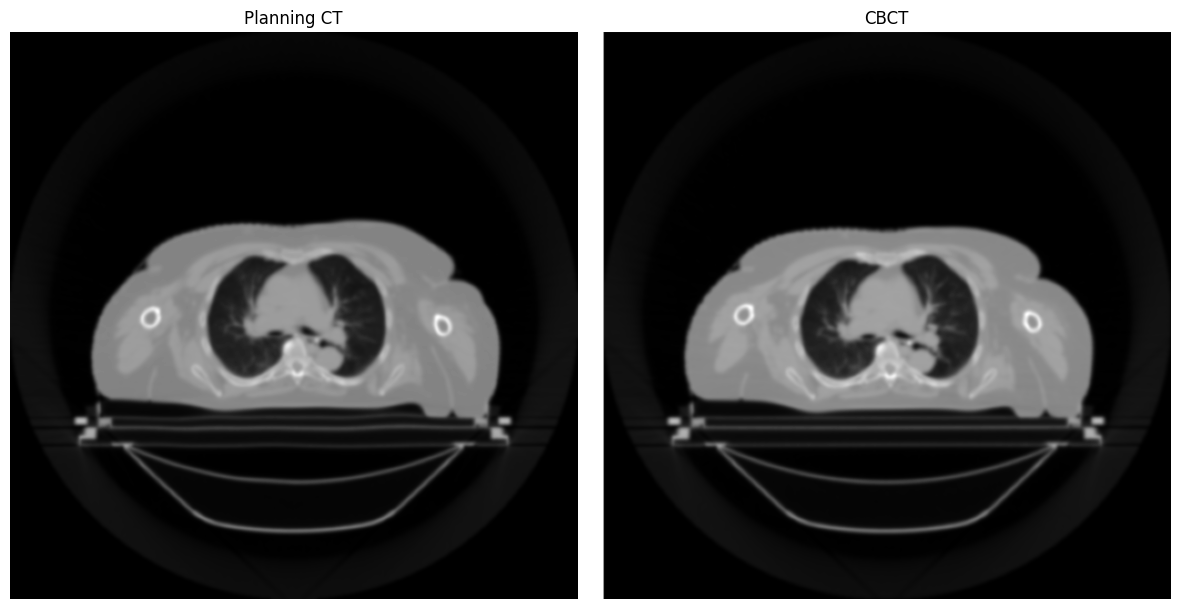

In [93]:
def perform_rigid_registration_v2(fixed_image, moving_image, sampling_percentage=0.1, learning_rate=1.0, num_iterations=100):
    """
    Performs rigid registration using SimpleITK's ImageRegistrationMethod.

    Args:
        fixed_image (sitk.Image): The reference image.
        moving_image (sitk.Image): The image to align to the fixed image.
        sampling_percentage (float): Fraction of pixels used for metric evaluation (e.g., 0.1 for 10%).
        learning_rate (float): Step size for the optimizer.
        num_iterations (int): Maximum number of optimizer iterations.

    Returns:
        sitk.Transform: The calculated rigid transform, or None if registration fails.
    """
    if fixed_image.GetDimension() != moving_image.GetDimension():
        print("Error: Fixed and moving images must have the same dimension.")
        return None
    # --- Initial Transform ---
    # Initialize with a rigid transform centered using image geometry.
    is_3d = fixed_image.GetDimension() == 3
    initial_transform = sitk.CenteredTransformInitializer(
        fixed_image,
        moving_image,
        sitk.Euler3DTransform() if is_3d else sitk.Euler2DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )

    # --- Registration Method Setup ---
    registration_method = sitk.ImageRegistrationMethod()

    # 1. Metric: Mattes Mutual Information
    # Good for multi-modality or mono-modality registration.
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    # Use a percentage of pixels for metric calculation for speed. Increase for stability.
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(sampling_percentage)

    # 2. Interpolator: Linear interpolation is standard.
    registration_method.SetInterpolator(sitk.sitkLinear)

    # 3. Optimizer: Gradient Descent
    # Often more robust than RegularStepGradientDescent.
    # Adjust learningRate and numberOfIterations as needed.
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=learning_rate,
        numberOfIterations=num_iterations,
        convergenceMinimumValue=1e-6, # Stop if metric value change is small
        convergenceWindowSize=10      # Over how many iterations to check convergence
    )

    # 4. Optimizer Scaling: Crucial for balancing rotation and translation steps.
    # Scales parameters based on the expected physical shift caused by a unit change.
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # 5. Initial Transform: Set the starting point for the optimizer.
    registration_method.SetInitialTransform(initial_transform)

    try:
        final_transform = registration_method.Execute(
            sitk.Cast(fixed_image, sitk.sitkFloat32), # Ensure float type
            sitk.Cast(moving_image, sitk.sitkFloat32)
        )

        print(final_transform)
        

        return final_transform

    except Exception as e:
        print(f"Error during registration execution: {e}")
        return None

# Example usage for global alignment:
global_transform = perform_rigid_registration_v2(smoothed_planning, smoothed_cbct)
# Resample to align moving image using the rigid transform.
moving_image_global_aligned = sitk.Resample(smoothed_cbct, smoothed_planning, global_transform,
                                              sitk.sitkLinear, 0.0, smoothed_cbct.GetPixelID())

plot_images(smoothed_planning, moving_image_global_aligned)

In [94]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

def perform_bspline_registration(fixed_image, moving_image, grid_physical_spacing=[50.0, 50.0, 50.0], 
                                 number_of_iterations=200):
    # 1. Determine the mesh size based on physical spacing.
    #    This defines the resolution of the BSpline grid.
    fixed_size = fixed_image.GetSize()
    fixed_spacing = fixed_image.GetSpacing()
    mesh_size = [int(np.round((fixed_size[i] * fixed_spacing[i]) / grid_physical_spacing[i])) for i in range(fixed_image.GetDimension())]
    
    # Initialize the BSpline transform.
    initial_transform = sitk.BSplineTransformInitializer(fixed_image, mesh_size)
    
    # 2. Configure the image registration method.
    registration_method = sitk.ImageRegistrationMethod()
    
    # Use Mattes Mutual Information for the metric (suitable for multimodal data)
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    
    # Interpolate using linear interpolation
    registration_method.SetInterpolator(sitk.sitkLinear)
    
    # Use LBFGSB optimizer for this non-rigid optimization.
    registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5,
                                             numberOfIterations=number_of_iterations,
                                             maximumNumberOfCorrections=5,
                                             maximumNumberOfFunctionEvaluations=1000,
                                             costFunctionConvergenceFactor=1e+7)
    
    # Set the initial BSpline transform.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    
    # Multi-resolution framework for a robust and faster convergence.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[8, 4, 2])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
    
    # 3. Execute registration.
    final_transform = registration_method.Execute(fixed_image, moving_image)
    print("Final BSpline registration metric value: {0}".format(registration_method.GetMetricValue()))
    print("Optimizer's stopping condition: {0}".format(registration_method.GetOptimizerStopConditionDescription()))
    
    return final_transform

def resample_with_transform(moving_image, fixed_image, transform):
    # Resample the moving image onto the fixed image grid using the provided transform.
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_image)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetTransform(transform)
    # Make sure the orientation matches the fixed image explicitly.
    resampler.SetOutputDirection(fixed_image.GetDirection())
    return resampler.Execute(moving_image)

# Example usage:
# Assume planning_ct_processed and cbct_processed are your preprocessed fixed and moving images.
# For demonstration, replace these with your actual image variables.
fixed_image = smoothed_planning   # e.g., planning CT (fixed)
moving_image = moving_image_global_aligned           # e.g., CBCT (moving)

# Perform deformable registration.
final_bspline_transform = perform_bspline_registration(fixed_image, moving_image, grid_physical_spacing=[50.0, 50.0, 50.0], number_of_iterations=200)

# Apply the BSpline transform to get the deformed (fused) image.
fused_deformed_image = resample_with_transform(moving_image, fixed_image, final_bspline_transform)

Final BSpline registration metric value: -1.517692316553043
Optimizer's stopping condition: LBFGSBOptimizerv4: Function tolerance reached after 57 iterations. The relative reduction of the cost function <= 2.22045e-09 = CostFunctionConvergenceFactor (1e+07) * machine precision (2.22045e-16).


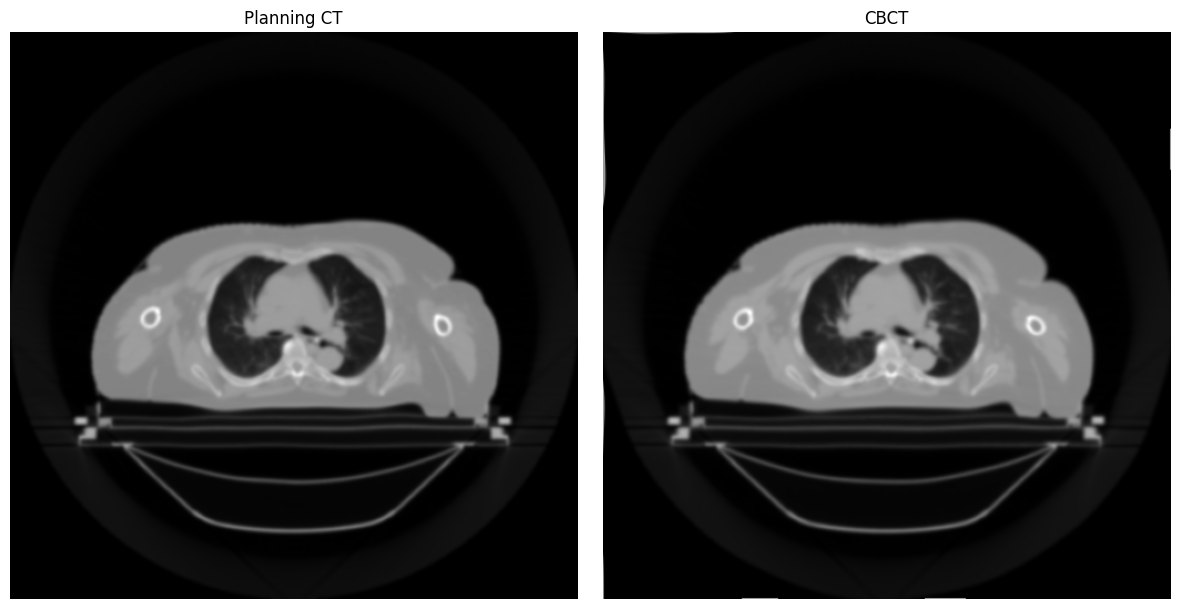

In [95]:
plot_images(fixed_image, fused_deformed_image)

In [96]:
import SimpleITK as sitk
import numpy as np
import time
import os

# Assume 'smoothed_planning' and 'smoothed_cbct' are loaded 2D sitk.Image objects
# Assume 'global_transform' is the 2D result from rigid registration or None
# Assume 'plot_images' function exists and handles 2D images

def perform_bspline_deformable_registration_2d(fixed_image, moving_image,
                                             grid_physical_spacing=[50.0, 50.0], # Provide 2 values for 2D!
                                             sampling_percentage=0.1,
                                             num_iterations=50,
                                             spline_order=3):
    """
    Performs 2D B-Spline Deformable Registration.
    Corrected version: Uses BSplineTransformInitializer with positional image argument.

    Args:
        fixed_image (sitk.Image): The 2D reference image.
        moving_image (sitk.Image): The 2D image to deformably align.
        initial_transform (sitk.Transform, optional): 2D global transform to initialize with.
        grid_physical_spacing (list[float]): Spacing (mm) between B-Spline control points (must have len 2).
        sampling_percentage (float): Fraction of pixels for metric evaluation.
        num_iterations (int): Max iterations *per multi-resolution level*.
        spline_order (int): Order of the B-spline (e.g., 3 for cubic).

    Returns:
        sitk.Transform: The calculated final (possibly composite) 2D transform, or None if fails.
    """


    # --- Initialize B-Spline Transform using BSplineTransformInitializer ---
    mesh_size = [int(np.ceil(sz * spc / gspc)) + spline_order -1
                 for sz, spc, gspc in zip(fixed_image.GetSize(),
                                          fixed_image.GetSpacing(),
                                          grid_physical_spacing)]

    bspline_transform_part = sitk.BSplineTransformInitializer(
        fixed_image, # Use as positional argument 1
        transformDomainMeshSize=mesh_size,
        order=spline_order
    )


    moving_image_globally_aligned = moving_image

    # --- Registration Method Setup ---
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(sampling_percentage)
    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsLBFGSB(
        gradientConvergenceTolerance=1e-5, numberOfIterations=num_iterations,
        maximumNumberOfCorrections=5,
        costFunctionConvergenceFactor=1e+7 )
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Initial Transform (set the B-spline part *for optimization*)
    registration_method.SetInitialTransform(bspline_transform_part, inPlace=False)

    # Multi-Resolution Framework (adjust shrink factors if needed for 2D)
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()


    registration_method.Execute(
        sitk.Cast(fixed_image, sitk.sitkFloat32),
        sitk.Cast(moving_image_globally_aligned, sitk.sitkFloat32)
    )
    return bspline_transform_part



control_point_spacing_2d = [40.0, 40.0] # Example: 4cm grid spacing in 2D

print(f"\nStarting 2D Deformable Registration with grid spacing: {control_point_spacing_2d} mm")
final_deformable_transform_2d = perform_bspline_deformable_registration_2d(
    fixed_image=smoothed_planning,
    moving_image=moving_image_global_aligned, # Use the globally aligned image
    grid_physical_spacing=control_point_spacing_2d,
    sampling_percentage=0.2, # Maybe increase sampling for 2D?
    num_iterations=50
)

print("\n2D Deformable registration successful.")
# Apply the final composite transform to the *original* moving image
moving_image_deformably_aligned_2d = sitk.Resample(
    moving_image_global_aligned,             # Original 2D moving image
    smoothed_planning,         # Reference space (2D fixed image)
    final_deformable_transform_2d,# The final (possibly composite) 2D transform
    sitk.sitkLinear,
    0.0,
    moving_image_global_aligned.GetPixelID()
)



Starting 2D Deformable Registration with grid spacing: [40.0, 40.0] mm


LBFGSBOptimizerv4 (0x7fda119fa430): LBFGSB optimizer does not support scaling. All scales are set to one.

LBFGSBOptimizerv4 (0x7fda119fa430): LBFGSB optimizer does not support scaling. All scales are set to one.

LBFGSBOptimizerv4 (0x7fda119fa430): LBFGSB optimizer does not support scaling. All scales are set to one.




2D Deformable registration successful.


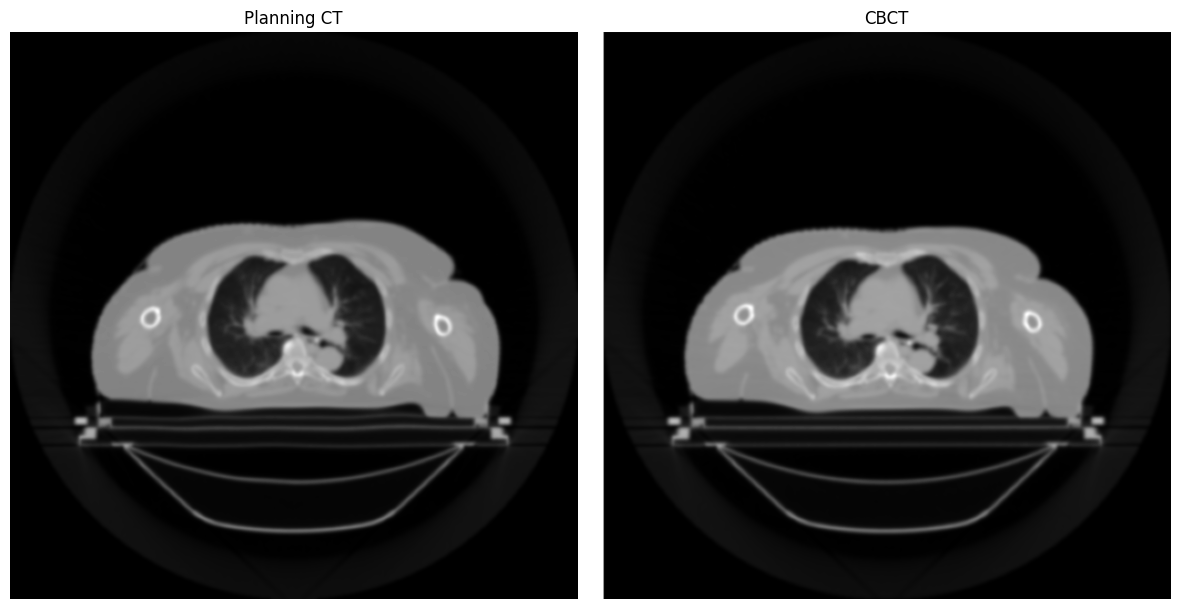

In [97]:
plot_images(smoothed_planning, moving_image_deformably_aligned_2d)

In [98]:
# def apply_transform(moving_image, transform, reference_image):
#     resampler = sitk.ResampleImageFilter()
#     resampler.SetReferenceImage(reference_image)
#     resampler.SetInterpolator(sitk.sitkLinear)
#     resampler.SetTransform(transform)
    
#     resampler.SetOutputDirection(reference_image.GetDirection())
#     return resampler.Execute(moving_image)

# # Get the fused image
# fused_ct = apply_transform(smoothed_cbct, transform, smoothed_planning)
# fused_ct = sitk.Flip(fused_ct, [True, True])


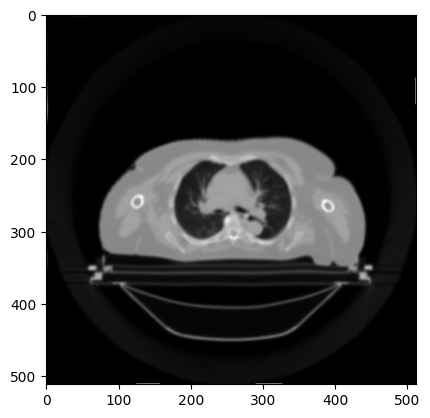

In [99]:
fused_image = sitk.GetArrayFromImage(fused_deformed_image)
plt.imshow(fused_image, cmap='gray')

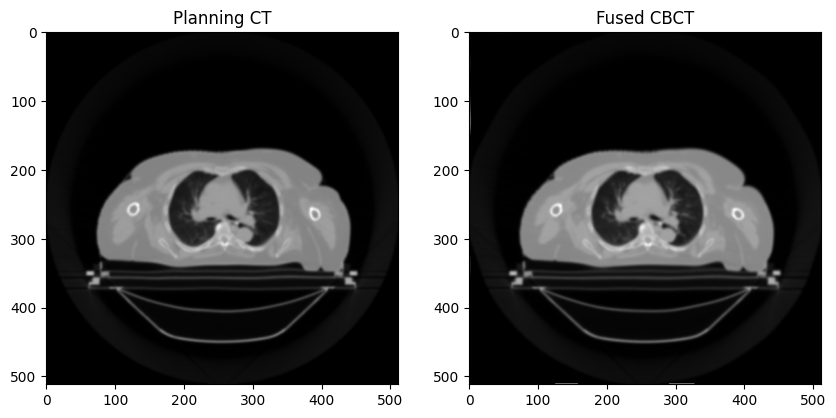

In [100]:
import matplotlib.pyplot as plt
import numpy as np

def display_overlay(fixed, moving, slice_index=50):
    fixed_array = sitk.GetArrayFromImage(fixed)
    moving_array = sitk.GetArrayFromImage(moving)
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('Planning CT')
    plt.imshow(fixed_array[:, :], cmap='gray')
    
    plt.subplot(1,2,2)
    plt.title('Fused CBCT')
    plt.imshow(moving_array[:, :], cmap='gray')
    plt.show()

display_overlay(smoothed_planning, fused_deformed_image)


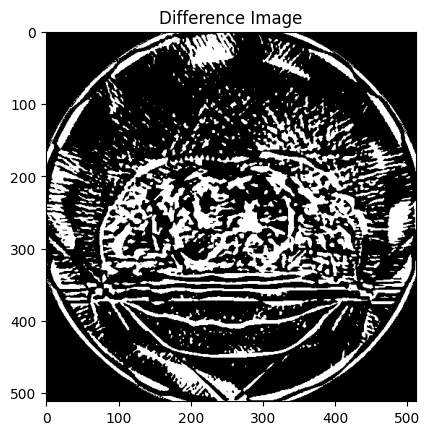

In [101]:
plot_difference(smoothed_planning, fused_deformed_image)